<a href="https://colab.research.google.com/github/LATHIKESHWARAN/HelixNova---AI-Driven-DNA-Synthetic-Sequence-Generator/blob/main/DNA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, math, time, random, json
from dataclasses import dataclass
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# plotting & metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
)

# reproducibility
RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)
torch.manual_seed(RSEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [ ]:
ALPHABET = ['A','C','G','T']            # realistic DNA alphabet
TOK2IDX = {t:i for i,t in enumerate(ALPHABET)}
IDX2TOK = {i:t for t,i in TOK2IDX.items()}

# class-specific DNA-like motifs
MOTIFS = {
    0: ["ATG"],         # start codon
    1: ["TATA"],        # promoter-like
    2: ["CGCG"],        # CpG island-ish
    3: ["GGG"]          # GC-rich motif
}

SEQ_LEN       = 300                    # sequence length
DATASET_SIZE  = 50000                  # total samples (train+val+test)
NUM_CLASSES   = len(MOTIFS)
BATCH_SIZE    = 256
EMBED_DIM     = 128
HIDDEN_DIM    = 256
NHEAD         = 4
NLAYERS       = 3
DROPOUT       = 0.1
EPOCHS        = 20
LR            = 1e-3
WEIGHT_DECAY  = 1e-5
PATIENCE      = 3

In [ ]:
def random_base(pA, pC, pG, pT):
    r = random.random()
    if r < pA: return 'A'
    r -= pA
    if r < pC: return 'C'
    r -= pC
    if r < pG: return 'G'
    return 'T'

def generate_dna_sequence(seq_len:int, class_id:int, gc_target:float) -> str:
    """
    Generate a DNA-like sequence of length seq_len with per-class motifs and a GC content bias.
    gc_target ~ desired fraction of G/C bases; A/T get the rest.
    Also add small sinusoidal structure so it's not iid.
    """
    # base probabilities (A/T vs G/C split by gc_target)
    pGC = gc_target
    pAT = 1.0 - pGC
    pG = pGC/2; pC = pGC/2; pA = pAT/2; pT = pAT/2

    seq = []
    for i in range(seq_len):
        # gentle positional modulation to create structure that Transformers can latch onto
        mod = 0.06 * math.sin(i/13.0 + class_id) + 0.04 * math.cos(i/29.0 - class_id*0.7)
        gct = min(0.9, max(0.1, pGC + mod))
        at  = 1.0 - gct
        g = gct/2; c = gct/2; a = at/2; t = at/2
        seq.append(random_base(a, c, g, t))

    # embed motifs for the class (one instance each, random positions)
    for motif in MOTIFS[class_id]:
        if len(motif) < seq_len:
            pos = random.randint(2, seq_len - len(motif) - 2)
            seq[pos:pos+len(motif)] = list(motif)

    return "".join(seq)

def build_dataset(n:int, seq_len:int) -> List[Tuple[str,int]]:
    """
    Balanced dataset across classes with different GC means per class.
    """
    data = []
    for i in range(n):
        class_id = i % NUM_CLASSES
        # per-class GC bias: center ~0.50 and slight shifts; add small noise
        base_gc = 0.50 + (class_id - NUM_CLASSES/2) * 0.04  # e.g., [-0.08, -0.04, 0.0, +0.04] shift
        gc_target = max(0.15, min(0.85, random.gauss(base_gc, 0.05)))
        seq = generate_dna_sequence(seq_len, class_id, gc_target)
        data.append((seq, class_id))
    random.shuffle(data)
    return data

data = build_dataset(DATASET_SIZE, SEQ_LEN)
print("Dataset size:", len(data))
print("Example:", data[0])

Dataset size: 50000
Example: ('GGAGTGAGCCAGATCCAAAATAGGAAATTAGACAGATTTGTGGCCTTGTGCGACAATAAAGTAGAGCGTACCTCAGGAACTTGTCAACCCCGAGGTGTGTTATGTAGTCCCACACCAGTTGCGCAAGTTCAATAGTTAGGGCGGTGTCACTCTACGCGATCCACCAGACGACCTGTTAAAAATGCTGTCTTGACCCTAGGGTGGACGATTCAATCTTATTCCACGGCCGAGCGGTCCGTCCGAGTGGAGGCCCGTGAAAACTACTGTCGGGCTAAGATCATCGTTAATAATTCGTTAAAA', 2)


In [ ]:
class DNADataset(Dataset):
    def __init__(self, data:List[Tuple[str,int]], tok2idx:Dict[str,int]):
        self.data = data
        self.tok2idx = tok2idx
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        seq, label = self.data[idx]
        ids = [self.tok2idx[ch] for ch in seq]  # fixed length SEQ_LEN
        return torch.tensor(ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)

full_ds = DNADataset(data, TOK2IDX)
n_train = int(0.8 * len(full_ds))
n_val   = int(0.1 * len(full_ds))
n_test  = len(full_ds) - n_train - n_val

train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(RSEED)
)
print("Splits:", len(train_ds), len(val_ds), len(test_ds))

Splits: 40000 5000 5000


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int, max_len:int=6000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div)
        pe[:, 1::2] = torch.cos(position * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class DNATransformer(nn.Module):
    def __init__(self, vocab_size:int, embed_dim:int, nhead:int, nhid:int, nlayers:int, n_classes:int, dropout:float):
        super().__init__()
        # +1 reserve for potential padding if you later variable-pad (not needed now but harmless)
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos = PositionalEncoding(embed_dim, max_len=SEQ_LEN+5)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=nhead, dim_feedforward=nhid, dropout=dropout, batch_first=False
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, nhid),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(nhid, n_classes)
        )

    def forward(self, x):                          # x: (B, L)
        B, L = x.size()
        emb = self.embed(x)                        # (B, L, E)
        cls = self.cls_token.expand(B, -1, -1)     # (B, 1, E)
        z = torch.cat([cls, emb], dim=1)           # (B, L+1, E)
        z = self.pos(z)                            # add positional enc
        z = z.permute(1,0,2)                       # (L+1, B, E) for encoder
        z = self.encoder(z)                        # (L+1, B, E)
        cls_out = z[0]                             # (B, E)
        cls_out = self.norm(cls_out)
        return self.head(cls_out)                  # (B, C)

model = DNATransformer(
    vocab_size=len(ALPHABET),
    embed_dim=EMBED_DIM,
    nhead=NHEAD,
    nhid=HIDDEN_DIM,
    nlayers=NLAYERS,
    n_classes=NUM_CLASSES,
    dropout=DROPOUT
).to(DEVICE)
print(model)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


DNATransformer(
  (embed): Embedding(4, 128)
  (pos): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(i

In [ ]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=1
)

In [ ]:
def train_epoch(model, loader, opt, criterion):
    model.train()
    total_loss, preds, trues = 0.0, [], []
    for x,y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
        preds.extend(torch.argmax(logits, dim=1).detach().cpu().tolist())
        trues.extend(y.detach().cpu().tolist())
    return total_loss/len(loader.dataset), accuracy_score(trues, preds)

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, preds, trues, probs_all = 0.0, [], [], []
    for x,y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        probs = torch.softmax(logits, dim=1)
        preds.extend(torch.argmax(probs, dim=1).cpu().tolist())
        probs_all.extend(probs.cpu().tolist())
        trues.extend(y.cpu().tolist())
    avg_loss = total_loss/len(loader.dataset)
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    return avg_loss, acc, f1, probs_all, trues, preds

In [ ]:
best_val, patience_ctr = 0.0, 0
save_path = "dna_transformer_best.pt"
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc, va_f1, *_ = eval_epoch(model, val_loader, criterion)
    scheduler.step(va_acc)
    dt = time.time() - t0

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc); history["val_f1"].append(va_f1)

    print(f"Epoch {epoch:02d}  Train {tr_loss:.4f}/{tr_acc:.4f}  |  Val {va_loss:.4f}/{va_acc:.4f}  F1 {va_f1:.4f}  ({dt:.1f}s)")
    if va_acc > best_val + 1e-5:
        best_val = va_acc
        torch.save(model.state_dict(), save_path)
        patience_ctr = 0
        print("  -> saved checkpoint")
    else:
        patience_ctr += 1
    if patience_ctr >= PATIENCE:
        print("Early stopping triggered.")
        break

model.load_state_dict(torch.load(save_path, map_location=DEVICE))

Epoch 01  Train 1.1286/0.4955  |  Val 1.0263/0.5694  F1 0.5732  (35.1s)
  -> saved checkpoint
Epoch 02  Train 0.9757/0.6079  |  Val 0.9765/0.5978  F1 0.5645  (34.5s)
  -> saved checkpoint
Epoch 03  Train 0.9083/0.6624  |  Val 0.9045/0.6682  F1 0.6525  (35.1s)
  -> saved checkpoint
Epoch 04  Train 0.8860/0.6806  |  Val 0.9055/0.6628  F1 0.6630  (35.4s)
Epoch 05  Train 0.8724/0.6895  |  Val 0.9003/0.6740  F1 0.6655  (35.5s)
  -> saved checkpoint
Epoch 06  Train 0.8721/0.6911  |  Val 0.8906/0.6688  F1 0.6749  (35.7s)
Epoch 07  Train 0.8642/0.6956  |  Val 0.9150/0.6658  F1 0.6530  (35.8s)
Epoch 08  Train 0.8495/0.7042  |  Val 0.8709/0.6958  F1 0.6894  (36.0s)
  -> saved checkpoint
Epoch 09  Train 0.8511/0.7033  |  Val 0.8698/0.6854  F1 0.6889  (36.1s)
Epoch 10  Train 0.8488/0.7047  |  Val 0.8625/0.6928  F1 0.6985  (36.3s)
Epoch 11  Train 0.8439/0.7078  |  Val 0.8588/0.7020  F1 0.6983  (37.1s)
  -> saved checkpoint
Epoch 12  Train 0.8441/0.7083  |  Val 0.8543/0.6992  F1 0.7003  (36.5s)
Epoc

<All keys matched successfully>

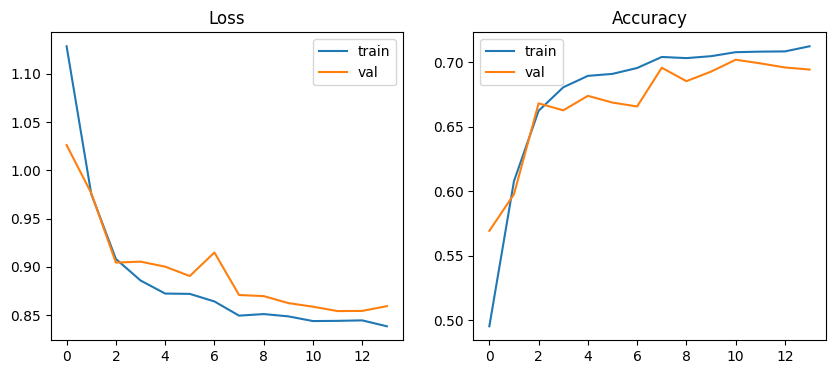

TEST  loss 0.8559  acc 0.6896  f1 0.6816


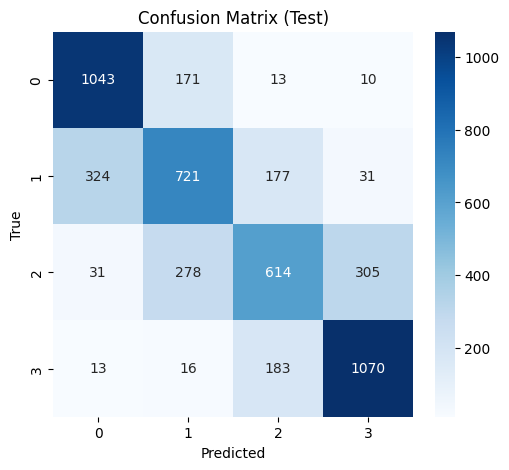

Class 0: P 0.739  R 0.843  F1 0.788
Class 1: P 0.608  R 0.575  F1 0.591
Class 2: P 0.622  R 0.500  F1 0.554
Class 3: P 0.756  R 0.835  F1 0.793


In [ ]:
@torch.no_grad()
def plot_curves(history):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(history["train_loss"], label="train")
    ax[0].plot(history["val_loss"],   label="val")
    ax[0].set_title("Loss"); ax[0].legend()
    ax[1].plot(history["train_acc"], label="train")
    ax[1].plot(history["val_acc"],   label="val")
    ax[1].set_title("Accuracy"); ax[1].legend()
    plt.show()

plot_curves(history)

test_loss, test_acc, test_f1, probs_all, trues, preds = eval_epoch(model, test_loader, criterion)
print("TEST  loss {:.4f}  acc {:.4f}  f1 {:.4f}".format(test_loss, test_acc, test_f1))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(5.8,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

for cls in range(NUM_CLASSES):
    p = precision_score(trues, preds, labels=[cls], average='macro', zero_division=0)
    r = recall_score(trues, preds, labels=[cls], average='macro',   zero_division=0)
    f = f1_score(trues, preds, labels=[cls], average='macro',       zero_division=0)
    print(f"Class {cls}: P {p:.3f}  R {r:.3f}  F1 {f:.3f}")

In [ ]:
IDX2LABEL = {
    0: "Class 0 (ATG-like)",
    1: "Class 1 (TATA-like)",
    2: "Class 2 (CGCG-like)",
    3: "Class 3 (GGG/GC-rich)"
}

def encode_seq(seq_str:str):
    return torch.tensor([[TOK2IDX[ch] for ch in seq_str]], dtype=torch.long, device=DEVICE)

@torch.no_grad()
def predict(seq_str:str):
    ids = encode_seq(seq_str)
    logits = model(ids)
    pred = int(torch.argmax(logits, dim=1).item())
    return pred, IDX2LABEL[pred], torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

# quick sanity: take one test sample
sx, sy = test_ds[0]
logits = model(sx.unsqueeze(0).to(DEVICE))
print("Sample pred:", int(torch.argmax(logits, dim=1).item()), "true:", int(sy.item()))

Sample pred: 1 true: 1


In [ ]:
def token_removal_attribution(seq_ids: torch.Tensor, target_class:int):
    """
    Simple, robust per-token importance by measuring score drop when token is masked (set to 'A').
    seq_ids: (1, L) on DEVICE
    returns: np.array shape (L,)
    """
    model.eval()
    with torch.no_grad():
        base = torch.softmax(model(seq_ids), dim=1)[0, target_class].item()

    atts = []
    L = seq_ids.size(1)
    for i in range(L):
        seq_mut = seq_ids.clone()
        # replace with least-informative token (choose 'A' index 0)
        seq_mut[0, i] = TOK2IDX['A']
        with torch.no_grad():
            p = torch.softmax(model(seq_mut), dim=1)[0, target_class].item()
        atts.append(base - p)
    return np.array(atts)

def show_top_tokens(seq_str, atts, k=10):
    idxs = np.argsort(-np.abs(atts))[:k]
    print("Top influential positions:")
    for pos in idxs:
        print(f"  pos {pos:03d} base '{seq_str[pos]}'  importance {atts[pos]:.4f}")

def try_captum_integrated_gradients(seq_ids: torch.Tensor, target_class:int):
    """
    Optional Captum IG: if captum is installed, compute LayerIntegratedGradients on embeddings.
    Returns np.array attributions or None if Captum unavailable.
    """
    try:
        from captum.attr import LayerIntegratedGradients
    except Exception as e:
        return None

    model.eval()

    def forward_ids(x_ids):
        return model(x_ids)

    lig = LayerIntegratedGradients(forward_ids, model.embed)
    # baseline = all 'A'
    baseline_ids = torch.full_like(seq_ids, fill_value=TOK2IDX['A'])
    attributions, _ = lig.attribute(
        inputs=seq_ids,
        baselines=baseline_ids,
        target=target_class,
        return_convergence_delta=True,
        n_steps=50
    )
    # attributions over embeddings -> reduce over embedding dim
    atts = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()  # (L,)
    return atts

# run explainability on a few samples
@torch.no_grad()
def explain_n_examples(n=3):
    it = iter(test_loader)
    x, y = next(it)
    x = x.to(DEVICE); y = y.to(DEVICE)
    for i in range(min(n, x.size(0))):
        seq_ids = x[i:i+1]
        true_label = int(y[i].item())
        logits = model(seq_ids)
        pred_label = int(torch.argmax(logits, dim=1).item())
        seq_str = "".join(IDX2TOK[int(t)] for t in seq_ids[0].tolist())

        # Captum IG first; fallback to token-removal if not available
        atts = try_captum_integrated_gradients(seq_ids, pred_label)
        if atts is None:
            atts = token_removal_attribution(seq_ids, pred_label)

        print(f"\nExample {i}  True: {true_label}  Pred: {pred_label} ({IDX2LABEL[pred_label]})")
        print("Seq (first 120):", seq_str[:120] + ("..." if len(seq_str)>120 else ""))
        show_top_tokens(seq_str, atts, k=10)

explain_n_examples(n=3)


Example 0  True: 1  Pred: 1 (Class 1 (TATA-like))
Seq (first 120): GAAGTTTGCTCCTGAATTGTAGCAAGGTATCATATAAATATGCTATGCTATATAGCCTGAATGAATTGAGAACGATAAATTTGAATCTGAAAAATCCGTTGCGCAAGACAGGAACCTTAT...
Top influential positions:
  pos 240 base 'C'  importance 0.0462
  pos 130 base 'G'  importance -0.0460
  pos 072 base 'C'  importance 0.0453
  pos 236 base 'C'  importance 0.0447
  pos 241 base 'G'  importance 0.0443
  pos 242 base 'G'  importance 0.0436
  pos 237 base 'C'  importance 0.0432
  pos 238 base 'G'  importance 0.0411
  pos 246 base 'G'  importance 0.0389
  pos 086 base 'C'  importance 0.0377

Example 1  True: 0  Pred: 0 (Class 0 (ATG-like))
Seq (first 120): CAACGAAGCCGACAAGCCGGCTTAGCATAACAATCGGGTATCACCCTAAACCACCTATAGCTACTTATAAAGATGATATCTCACTCGGACAATTCTTAAGCTTCCACCTGTTTCACAATT...
Top influential positions:
  pos 243 base 'C'  importance -0.0398
  pos 244 base 'C'  importance -0.0393
  pos 235 base 'C'  importance -0.0354
  pos 233 base 'C'  importance -0.0344
  pos 079 base 'C'  import